# Content


### 1. Map Reduce

### 2. ...

### 3. ...


In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    TypedDict,
    Union,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from utilities.client_utils import check_rate_limit  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


# Map Reduce

### Map

- This involves breaking a task into smaller sub-tasks, processing each sub-task in parallel.

### Reduce

-  This involves combining/aggregating the results of the completed, parallelized sub-tasks.

In [ ]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langchain_litellm import ChatLiteLLM
from langchain_tavily import TavilySearch
from langfuse.callback import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt


In [14]:
# Prompts
subject_prompt: str = """
    <instruction>
    Generate a list of 3 sub-topics that are all 
    related to this overall topic: {topic!r} 
    </instruction>
"""

joke_prompt: str = "<instruction>Generate a joke about {subject!r}.</instruction>"
best_joke_prompt: str = """
    <instruction>
    Below are a bunch of jokes about {topic!r}. Select the best one! Return the ID 
    of the best one, starting 0 as the ID for the first joke. Jokes: \n\n{jokes}
    </instruction>
"""

model_str: str = "mistralai:ministral-8b-latest"
llm = init_chat_model(model=model_str, temperature=0.0)

## Parallelizing Joke Generation

- Define a graph that will:
  - take a user input topic
  - produce a list of joke topics fro it
  - send each joke topic to the LLM
- The state has a `jokes` key that will accumulate jokes from parallelized joke generations.

In [10]:
from pydantic import BaseModel, Field


class Subjects(BaseModel):
    subjects: list[str] = Field(description="List of subjects related to the topic.")


class BestJoke(BaseModel):
    id: int = Field(description="ID of the best joke selected from the list of jokes.")


class OverallState(TypedDict):
    topic: str
    subjects: list[str]
    jokes: Annotated[list[str], add_messages]
    best_selected_joke: str

In [20]:
OverallState(
    topic="Chinedu",
    subjects=["love", "work"],
    jokes=[],
    best_selected_joke="",
)
prompt: str = subject_prompt.format(topic="animals")
print(prompt)

response = await llm.with_structured_output(Subjects).ainvoke(prompt)
print(response)


    <instruction>
    Generate a list of 3 sub-topics that are all 
    related to this overall topic: 'animals' 
    </instruction>

subjects=['Mammals', 'Birds', 'Reptiles']


In [21]:
async def generate_topics(state: OverallState) -> dict[str, Any]:
    """Generate a list of subjects based on a given topic.

    Parameters:
        state (OverallState): The current state containing the topic to generate subjects for.
            Expected to have a 'topic' key with a string value.

    Returns:
        dict[str, Any]

    Notes:
        Uses an LLM to generate structured output in the form of Subjects.
    """
    prompt: str = subject_prompt.format(topic=state["topic"])
    response: Subjects = await llm.with_structured_output(Subjects).ainvoke(prompt)
    return {"subjects": response.subjects}

### Send Function

- In LangGraph, Nodes and Edges usually share a predefined state. However, for dynamic cases like map-reduce, LangGraph uses `Send` objects in conditional edges.
- It can be used to parallelize tasks

In [8]:
user_input: str = "Who is Chinedu? What does he do? "
config = {"configurable": {"thread_id": "1"}}

events = graph.astream(
    {"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values",
)

try:
    async for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()

except Exception as e:
    console.print(f"Error: {e}")

================================ Human Message =================================

Who is Chinedu? What does he do? 
================================== Ai Message ==================================
Tool Calls:
  local_wikipedia (pmkcv56UH)
 Call ID: pmkcv56UH
  Args:
    name: Chinedu
================================= Tool Message =================================
Name: local_wikipedia

Chinedu, AKA Tha-dude, is a data scientist who is transitioning into AI Engineering. He resides in Lagos State and he's focusing on building and deploying practical AI solutions relevant to the Nigerian context. He enjoys learning new things and developing new projects. He is currently working on a project that will help Nigerians learn how to use AI to solve their problems. 
================================== Ai Message ==================================

Chinedu is a data scientist transitioning into AI Engineering. He is based in Lagos State and is focused on building and deploying practical AI soluti

In [9]:
user_input: str = "What is 7 plus 3? Divide the result by 4"

events = graph.astream(
    {"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values",
)

try:
    async for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()

except Exception as e:
    console.print(f"Error: {e}")

================================ Human Message =================================

What is 7 plus 3? Divide the result by 4
================================== Ai Message ==================================
Tool Calls:
  adder (39oEfH6p9)
 Call ID: 39oEfH6p9
  Args:
    a: 7
    b: 3
  divider (xsM5zdtxi)
 Call ID: xsM5zdtxi
  Args:
    a: 10
    b: 4
================================= Tool Message =================================
Name: divider

2.5
================================== Ai Message ==================================

The result of 7 plus 3 is 10. Dividing this result by 4 gives 2.5.


## State Reducers

- Multiple messages can be concatenated using: 
  - Using operator.add
  - Using langgraph's add_message function

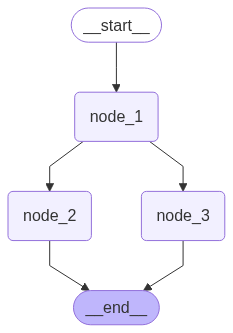

In [10]:
from operator import add


class DefaultState(TypedDict):
    messages: list


class StateWithOperatorAdd(TypedDict):
    messages: Annotated[list, add]


class StateWithAddMessages(TypedDict):
    messages: Annotated[list, add_messages]


def node_1(state: DefaultState) -> dict[str, Any]:
    print("node 1")
    return {"messages": state["messages"]}


def node_2(state: DefaultState) -> dict[str, Any]:
    print("node 2")
    return {"messages": ["processed"]}


def node_3(state: DefaultState) -> dict[str, Any]:
    print("node 3")
    return {"messages": ["processed"]}


graph_builder = StateGraph(DefaultState)
graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)
graph_builder.add_node("node_3", node_3)

graph_builder.add_edge(START, "node_1")
graph_builder.add_edge("node_1", "node_2")
graph_builder.add_edge("node_1", "node_3")
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)


graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

<br>

### Comment

- When we use the `DefaultState` as the state type, there's no way to concatenate the messages, we get an error because multiple steps/nodes can't write to the same field at the same time.
- To solve this, we can use `StateWithOperatorAdd` or `StateWithAddMessages`

In [11]:
from langgraph.errors import InvalidUpdateError

try:
    result = graph.invoke({"messages": ["Hello"]})
    pprint(result)
except InvalidUpdateError as e:
    console.log(f"Error: {e}")

node 1
node 2
node 3


[21:11:46] Error: At key 'messages': Can receive only one value per step. Use an Annotated key to   ]8;id=485685;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/3042397884.py\3042397884.py]8;;\:]8;id=885527;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/3042397884.py#7\7]8;;\
           handle multiple values.                                                                                 
           For troubleshooting, visit:                                                                             
           https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE                

In [12]:
# how add_messages works.
initial_message: list[Any] = [
    {"role": "user", "content": "Hello"},
    {"role": "assistant", "content": "Hi there!"},
]

# Add new message
new_message: dict[str, Any] = {"role": "user", "content": "How are you?"}

# Use add_messages to create a new list with the new message added
add_messages_result: list[Any] = add_messages(initial_message, new_message)
console.log(f"Result of add_messages: {add_messages_result}")

[21:11:47] Result of add_messages: [HumanMessage(content='Hello', additional_kwargs={},            ]8;id=665030;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/2283970116.py\2283970116.py]8;;\:]8;id=40000;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/2283970116.py#12\12]8;;\
           response_metadata={}, id='9e3ab599-a1bd-4a83-ba7c-16f6e47704b9'), AIMessage(content='Hi                 
           there!', additional_kwargs={}, response_metadata={},                                                    
           id='a7e271aa-feab-47bb-993c-dd83a07b42e2'), HumanMessage(content='How are you?',                        
           additional_kwargs={}, response_metadata={}, id='3a42c37f-17d2-4b8f-a50b-3d175cf9518a')]                 

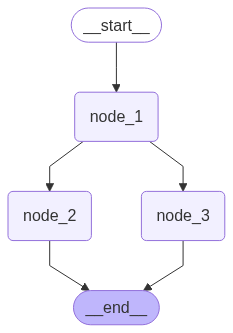

In [13]:
def node_1(state: StateWithOperatorAdd) -> dict[str, Any]:
    print("node 1")
    return {"messages": state["messages"]}


def node_2(state: StateWithOperatorAdd) -> dict[str, Any]:
    print("node 2")
    return {"messages": ["processed"]}


def node_3(state: StateWithOperatorAdd) -> dict[str, Any]:
    print("node 3")
    return {"messages": ["processed"]}


graph_builder = StateGraph(StateWithOperatorAdd)
graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)
graph_builder.add_node("node_3", node_3)

graph_builder.add_edge(START, "node_1")
graph_builder.add_edge("node_1", "node_2")
graph_builder.add_edge("node_1", "node_3")
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)


graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
try:
    result = graph.invoke({"messages": ["Hello"]})
    pprint(result)
except InvalidUpdateError as e:
    console.log(f"Error: {e}")

node 1
node 2
node 3
{'messages': ['Hello', 'Hello', 'processed', 'processed']}


In [15]:
try:
    result = graph.invoke({"messages": None})
    pprint(result)
except (InvalidUpdateError, TypeError) as e:
    console.log(f"Error: {e}")

[21:11:52] Error: can only concatenate list (not "NoneType") to list                                 ]8;id=843668;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/819682595.py\819682595.py]8;;\:]8;id=836733;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/819682595.py#5\5]8;;\

### Custom Reducers

- We can create custom reducers for handlng edge cases.

In [16]:
def reduce_list(left: list[list[Any]] | None, right: list[Any] | None) -> list[Any]:
    """Reduce two lists into one."""
    if left is None:
        left = []
    if right is None:
        right = []
    return left + right

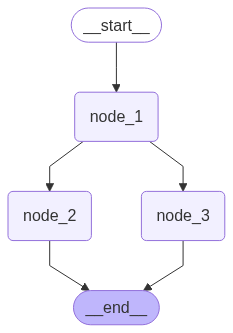

In [17]:
class StateWithCustomReducer(TypedDict):
    messages: Annotated[list, reduce_list]


def node_1(state: StateWithCustomReducer) -> dict[str, Any]:
    print("node 1")
    return {"messages": state["messages"]}


def node_2(state: StateWithCustomReducer) -> dict[str, Any]:
    print("node 2")
    return {"messages": ["processed"]}


def node_3(state: StateWithCustomReducer) -> dict[str, Any]:
    print("node 3")
    return {"messages": ["processed"]}


graph_builder = StateGraph(StateWithCustomReducer)
graph_builder.add_node("node_1", node_1)
graph_builder.add_node("node_2", node_2)
graph_builder.add_node("node_3", node_3)

graph_builder.add_edge(START, "node_1")
graph_builder.add_edge("node_1", "node_2")
graph_builder.add_edge("node_1", "node_3")
graph_builder.add_edge("node_2", END)
graph_builder.add_edge("node_3", END)


graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
try:
    result = graph.invoke({"messages": None})
    pprint(result)
except (InvalidUpdateError, TypeError) as e:
    console.log(f"Error: {e}")

node 1
node 2
node 3
{'messages': ['processed', 'processed']}


<hr><br>

## Multiple Schemas

- We can use specific schemas for the input and output of the graph.
- This can be based on the relevant keys in the input and output.

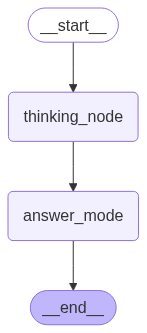

In [19]:
class InputState(TypedDict):
    question: str


class OutputState(TypedDict):
    answer: str


class OverallState(TypedDict):
    question: str
    answer: str
    notes: str


def thinking_node(state: InputState) -> dict[str, str]:
    return {"answer": "bye", "notes": "... his name is Neidu"}


def answer_mode(state: OverallState) -> OutputState:
    return {"answer": "bye Neidu"}


# Build the state graph
graph_builder = StateGraph(OverallState, input=InputState, output=OutputState)
graph_builder.add_node("thinking_node", thinking_node)
graph_builder.add_node("answer_mode", answer_mode)

# Connect nodes
graph_builder.add_edge(START, "thinking_node")
graph_builder.add_edge("thinking_node", "answer_mode")
graph_builder.add_edge("answer_mode", END)

# Compile the graph and visualize it
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
result = graph.invoke({"question": "What is your name?"})
pprint(result)

{'answer': 'bye Neidu'}


<hr><br>


## Filtering And Trimming Messages

- To avoid sending too many messages to the LLM especially as the context grows, we can filter and trim the messages.

### 1. Using A Reducer To Remove Messages
- Using `add_messages`  and `RemoveMessage`
- This modifies the graph's state.

#### Observability

- You can view the traces using `LangFuse` or any other observability tool.

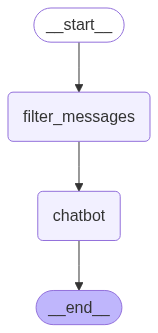

In [ ]:
from langchain_core.messages import RemoveMessage


class MessageState(TypedDict):
    messages: Annotated[list[Any], add_messages]


def filter_messages(state: MessageState) -> dict[str, Any]:
    # Delete all but the N most recent messages
    N: int = 3
    deleted_messages: list[Any] = [RemoveMessage(id=m.id) for m in state["messages"][:-N]]
    return {"messages": deleted_messages}


async def chatbot(state: MessageState) -> dict[str, Any]:
    response = await llm.ainvoke(state["messages"])
    return {"messages": [response]}


# Build the state graph
graph_builder = StateGraph(MessageState)

# Add Nodes
graph_builder.add_node("filter_messages", filter_messages)
graph_builder.add_node("chatbot", chatbot)

# Connect nodes
graph_builder.add_edge(START, "filter_messages")
graph_builder.add_edge("filter_messages", "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph and visualize it
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}
messages: list[Any] = [
    {"role": "user", "content": "Hi!"},
    {"role": "assistant", "content": "Hello"},
    {"role": "user", "content": "I'm Chinedu."},
    {"role": "assistant", "content": "Hello, how can I help you today?"},
    {"role": "user", "content": "can you remember my name?"},
]

async for message in graph.astream({"messages": messages}, config=config, stream_mode="values"):
    if "messages" in message:
        message["messages"][-1].pretty_print()

================================ Human Message =================================

can you remember my name?
================================ Human Message =================================

can you remember my name?
================================== Ai Message ==================================

Yes, I can remember your name. You are Chinedu. How can I assist you today?


In [32]:
message

{'messages': [AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={}, id='8920da96-a643-4b08-91cb-e1514e536a08'),
  HumanMessage(content='can you remember my name?', additional_kwargs={}, response_metadata={}, id='8f58e3e9-20ab-4015-aee9-b552a60653c5'),
  AIMessage(content="I don't have the ability to remember or store personal information between interactions. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 21, 'total_tokens': 44, 'completion_tokens': 23}, 'model_name': 'ministral-8b-latest', 'model': 'ministral-8b-latest', 'finish_reason': 'stop'}, id='run--072aa728-6d2b-4659-a0d4-3b7056b1c988-0', usage_metadata={'input_tokens': 21, 'output_tokens': 23, 'total_tokens': 44})]}

<br>

### 2. Filtering Messages Without Modifying The Graph's State

- This can be done by selecting a slice of the message history.
- i.e. `state["messages"][-N:]`

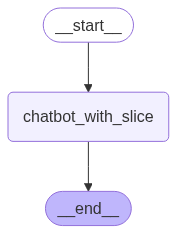

In [35]:
async def chatbot_with_slice(state: MessageState) -> dict[str, Any]:
    N: int = 3
    response = await llm.ainvoke(state["messages"][-N:])
    return {"messages": [response]}


# Build the state graph
graph_builder = StateGraph(MessageState)

# Add Nodes
graph_builder.add_node("chatbot_with_slice", chatbot_with_slice)

# Connect nodes
graph_builder.add_edge(START, "chatbot_with_slice")
graph_builder.add_edge("chatbot_with_slice", END)

# Compile the graph and visualize it
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}
messages: list[Any] = [
    {"role": "user", "content": "Hi!"},
    {"role": "assistant", "content": "Hello"},
    {"role": "user", "content": "I'm Chinedu."},
    {"role": "assistant", "content": "Hello, how can I help you today?"},
    {"role": "user", "content": "can you remember my name?"},
]

async for message in graph.astream({"messages": messages}, config=config, stream_mode="values"):
    if "messages" in message:
        message["messages"][-1].pretty_print()

================================ Human Message =================================

can you remember my name?
================================== Ai Message ==================================

Yes, I can remember your name. You are Chinedu. How can I assist you today?


### Comment

- Only the last N messages are used to generate the response.

### Trim Messages

- This approach trims the messages based upon the set number of tokens.
- It uses the langchain's `trim_messages` function.

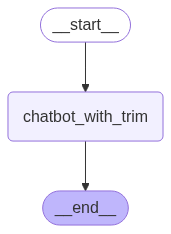

In [45]:
from langchain_core.messages import trim_messages


async def chatbot_with_trim(state: MessageState) -> dict[str, Any]:
    messages = trim_messages(
        messages=state["messages"],
        max_tokens=100,
        token_counter=llm,
        strategy="last",  # keep the last N messages
        allow_partial=False,  # allow partial messages
    )
    response = await llm.ainvoke(messages)
    return {"messages": [response]}


# Build the state graph
graph_builder = StateGraph(MessageState)

# Add Nodes
graph_builder.add_node("chatbot_with_trim", chatbot_with_trim)

# Connect nodes
graph_builder.add_edge(START, "chatbot_with_trim")
graph_builder.add_edge("chatbot_with_trim", END)

# Compile the graph and visualize it
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}
messages: list[Any] = [
    {"role": "user", "content": "Hi!"},
    {"role": "assistant", "content": "Hello"},
    {"role": "user", "content": "I'm Chinedu."},
    {"role": "assistant", "content": "Hello, how can I help you today?"},
    {"role": "user", "content": "can you remember my name?"},
]

async for message in graph.astream({"messages": messages}, config=config, stream_mode="values"):
    if "messages" in message:
        message["messages"][-1].pretty_print()

================================ Human Message =================================

can you remember my name?
================================== Ai Message ==================================

Yes, I can remember your name. You told me your name is Chinedu. How can I assist you today, Chinedu?


<br><br>

## Chat Summarization

- Instead of trimming or filtering messages, we can summarize the chat history (using an LLM) to keep the context while reducing the number of messages.

In [ ]:
class MessageState(TypedDict):
    messages: Annotated[list[Any], add_messages]
    summary: str


# Nodes
async def summarize_history(state: MessageState) -> dict[str, Any]:
    """
    Summarize conversation history and manage message retention.

    Parameters:
        state (MessageState): Current state containing messages and summary.

    Returns:
        dict[str, Any]
            Dictionary containing new summary and messages to be deleted.
    """
    summary: str = state.get("summary", "")

    if summary:
        summary_msg: str = f"This is the summary of the conversation so far: {summary}\n\n"
        "Extend this summary by taking into account the new messages above:"
    else:
        summary_msg: str = "Create a summary of the conversation so far:\n\n"

    messages: list[Any] = state["messages"] + [HumanMessage(content=summary_msg)]
    response: Any = await llm.ainvoke(messages)

    # Delete all but the last N messages
    N: int = 2
    deleted_messages: list[Any] = [RemoveMessage(id=m.id) for m in state["messages"][:-N]]

    return {"summary": response.content, "messages": deleted_messages}


async def chatbot_with_summary(state: MessageState) -> dict[str, Any]:
    summary: str = state.get("summary", "")
    if summary:
        summary_msg: str = f"This is the summary of the conversation so far: {summary}\n\n"
        messages: list[Any] = [SystemMessage(content=summary_msg)] + state["messages"]
    else:
        messages = state["messages"]

    response = await llm.ainvoke(messages)

    return {"messages": [response]}


def should_summarize(state: MessageState) -> Literal[END, "summarize"]:
    """
    Determine if conversation history should be summarized.

    Parameters:
        state (MessageState): Current state containing messages and summary.

    Returns:
        Literal["summarize", END]
            "summarize" if messages exceed threshold, END otherwise.
    """
    messages: list[Any] = state["messages"]
    # If there are more than 5 messages, we summarize
    if len(messages) > 5:
        return "summarize"

    # Otherwise, we end the conversation
    return END

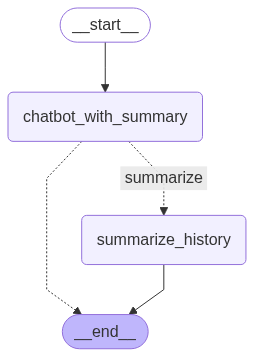

In [ ]:
from langfuse.callback import CallbackHandler


graph_builder = StateGraph(MessageState)

# Add Nodes
graph_builder.add_node("summarize_history", summarize_history)
graph_builder.add_node("chatbot_with_summary", chatbot_with_summary)

# Connect nodes
graph_builder.add_edge(START, "chatbot_with_summary")
graph_builder.add_conditional_edges(
    "chatbot_with_summary",
    should_summarize,
    # From Output --> Node
    {
        "summarize": "summarize_history",
        END: END,
    },
)
graph_builder.add_edge("summarize_history", END)

# Compile the graph and visualize it
memory = MemorySaver()
langfuse_handler = CallbackHandler()
graph = graph_builder.compile(checkpointer=memory).with_config({"callbacks": [langfuse_handler]})

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}
messages: list[Any] = [
    {"role": "user", "content": "Hi!"},
    {"role": "assistant", "content": "Hello"},
    {"role": "user", "content": "How are you doing?"},
    {"role": "assistant", "content": "I'm doing well, thank you!"},
    {"role": "user", "content": "I'm Chinedu."},
    {"role": "assistant", "content": "Hello, how can I help you today?"},
    {"role": "user", "content": "can you remember my name?"},
]

async for message in graph.astream({"messages": messages}, config=config, stream_mode="values"):
    if "messages" in message:
        message["messages"][-1].pretty_print()

================================ Human Message =================================

can you remember my name?
================================== Ai Message ==================================

Yes, I can remember your name. You are Chinedu. How can I assist you today?
================================== Ai Message ==================================

Yes, I can remember your name. You are Chinedu. How can I assist you today?


In [86]:
messages_copy: list[Any] = messages.copy()[-2:]

In [87]:
response: dict[str, Any] = {
    "role": "assistant",
    "content": message["messages"][-1].content,
}
messages_copy.append(response)

message: dict[str, Any] = {
    "role": "user",
    "content": "Okay, what is the meaning of flash attention in AI?",
}

messages_copy.append(message)

console.log(messages_copy)

[16:11:31] [                                                                                       ]8;id=167782;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/3450595926.py\3450595926.py]8;;\:]8;id=960166;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/3450595926.py#14\14]8;;\
               {'role': 'assistant', 'content': 'Hello, how can I help you today?'},                               
               {'role': 'user', 'content': 'can you remember my name?'},                                           
               {                                                                                                   
                   'role': 'assistant',                                                                            
                   'content': 'Yes, I can remember your name. You are Chinedu. How can I assist                    
           you today?'                                                                                             
               },                                                                                                  
               {                                                                                                   
                   'role': 'user',                                                                                 
                   'content': 'Okay, what is the meaning of flash attention in AI?'                                
               }                                                                                                   
           ]                                                                                                       

In [88]:
async for message in graph.astream(
    {"messages": messages_copy}, config=config, stream_mode="values"
):
    if "messages" in message:
        message["messages"][-1].pretty_print()

================================ Human Message =================================

Okay, what is the meaning of flash attention in AI?
================================== Ai Message ==================================

Flash attention is a technique used in natural language processing (NLP) to improve the efficiency of attention mechanisms in transformer models. Traditional attention mechanisms, such as the one used in the original Transformer model, compute attention scores for all pairs of tokens in a sequence, which can be computationally expensive and slow, especially for long sequences.

Flash attention addresses this issue by using a more efficient algorithm to compute attention scores. It leverages the fact that many attention scores are zero or close to zero, and it uses this sparsity to reduce the computational cost. Flash attention also uses a technique called "flash" to compute the attention scores in a more parallelizable and efficient manner.

The main benefits of flash atten

In [89]:
messages_copy: list[Any] = messages_copy.copy()[-2:]
response: dict[str, Any] = {
    "role": "assistant",
    "content": message["messages"][-1].content,
}
messages_copy.append(response)

message: dict[str, Any] = {
    "role": "user",
    "content": "Do you know about vLLM? Does it use flash attention?",
}

messages_copy.append(message)

console.log(messages_copy)

[16:12:43] [                                                                                       ]8;id=182463;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/3085105929.py\3085105929.py]8;;\:]8;id=397044;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/3085105929.py#15\15]8;;\
               {                                                                                                   
                   'role': 'assistant',                                                                            
                   'content': 'Yes, I can remember your name. You are Chinedu. How can I assist                    
           you today?'                                                                                             
               },                                                                                                  
               {                                                                                                   
                   'role': 'user',                                                                                 
                   'content': 'Okay, what is the meaning of flash attention in AI?'                                
               },                                                                                                  
               {                                                                                                   
                   'role': 'assistant',                                                                            
                   'content': 'Flash attention is a technique used in natural language processing                  
           (NLP) to improve the efficiency of attention mechanisms in transformer models.                          
           Traditional attention mechanisms, such as the one used in the original Transformer                      
           model, compute attention scores for all pairs of tokens in a sequence, which can be                     
           computationally expensive and slow, especially for long sequences.\n\nFlash attention                   
           addresses this issue by using a more efficient algorithm to compute attention scores.                   
           It leverages the fact that many attention scores are zero or close to zero, and it uses                 
           this sparsity to reduce the computational cost. Flash attention also uses a technique                   
           called "flash" to compute the attention scores in a more parallelizable and efficient                   
           manner.\n\nThe main benefits of flash attention include:\n\n1. **Faster computation**:                  
           Flash attention can significantly speed up the computation of attention scores, making                  
           it more suitable for real-time applications.\n2. **Reduced memory usage**: By                           
           exploiting the sparsity of attention scores, flash attention can reduce the memory                      
           footprint of the model.\n3. **Improved scalability**: Flash attention allows for better                 
           scalability, enabling the processing of longer sequences and larger models.\n\nOverall,                 
           flash attention is a valuable technique for improving the efficiency and performance of                 
           transformer models in NLP tasks.'                                                                       
               },                                                                                                  
               {                                                                                                   
                   'role': 'user',                                                                                 
                   'content': 'Do you know about vLLM? Does it use fl

In [90]:
async for message in graph.astream(
    {"messages": messages_copy}, config=config, stream_mode="values"
):
    if "messages" in message:
        message["messages"][-1].pretty_print()

================================ Human Message =================================

Do you know about vLLM? Does it use flash attention?
================================== Ai Message ==================================

Yes, vLLM (Vectorized Large Language Models) is a framework designed to improve the efficiency and performance of large language models. While vLLM itself is not specifically known for using flash attention, it often incorporates various optimization techniques to enhance the efficiency of attention mechanisms.

Flash attention, as discussed earlier, is a technique that can be used to optimize the computation of attention scores in transformer models. It is particularly useful for reducing computational cost and memory usage, making it a valuable addition to frameworks like vLLM.

If vLLM incorporates flash attention, it would benefit from the faster computation and reduced memory usage that this technique provides, making it more efficient for handling large language mode

In [91]:
messages_copy: list[Any] = messages_copy.copy()[-2:]

response: dict[str, Any] = {
    "role": "assistant",
    "content": message["messages"][-1].content,
}
messages_copy.append(response)

message: dict[str, Any] = {
    "role": "user",
    "content": "Can you remember my name? I think you forgot it.",
}

messages_copy.append(message)

console.log(messages_copy)

[16:13:18] [                                                                                        ]8;id=181712;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/297472973.py\297472973.py]8;;\:]8;id=298519;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_68572/297472973.py#16\16]8;;\
               {                                                                                                   
                   'role': 'assistant',                                                                            
                   'content': 'Flash attention is a technique used in natural language processing                  
           (NLP) to improve the efficiency of attention mechanisms in transformer models.                          
           Traditional attention mechanisms, such as the one used in the original Transformer                      
           model, compute attention scores for all pairs of tokens in a sequence, which can be                     
           computationally expensive and slow, especially for long sequences.\n\nFlash attention                   
           addresses this issue by using a more efficient algorithm to compute attention scores. It                
           leverages the fact that many attention scores are zero or close to zero, and it uses                    
           this sparsity to reduce the computational cost. Flash attention also uses a technique                   
           called "flash" to compute the attention scores in a more parallelizable and efficient                   
           manner.\n\nThe main benefits of flash attention include:\n\n1. **Faster computation**:                  
           Flash attention can significantly speed up the computation of attention scores, making                  
           it more suitable for real-time applications.\n2. **Reduced memory usage**: By exploiting                
           the sparsity of attention scores, flash attention can reduce the memory footprint of the                
           model.\n3. **Improved scalability**: Flash attention allows for better scalability,                     
           enabling the processing of longer sequences and larger models.\n\nOverall, flash                        
           attention is a valuable technique for improving the efficiency and performance of                       
           transformer models in NLP tasks.'                                                                       
               },                                                                                                  
               {                                                                                                   
                   'role': 'user',                                                                                 
                   'content': 'Do you know about vLLM? Does it use flash attention?'                               
               },                                                                                                  
               {                                                                                                   
                   'role': 'assistant',                                                                            
                   'content': 'Yes, vLLM (Vectorized Large Language Models) is a framework designed                
           to improve the efficiency and performance of large language models. While vLLM itself is                
           not specifically known for using flash attention, it often incorporates various                         
           optimization techniques to enhance the efficiency of attention mechanisms.\n\nFlash                     
           attention, as discussed earlier, is a technique that can be used to optimize the                        
           computation of attention scores in transformer models. It is

In [92]:
async for message in graph.astream(
    {"messages": messages_copy}, config=config, stream_mode="values"
):
    if "messages" in message:
        message["messages"][-1].pretty_print()

================================ Human Message =================================

Can you remember my name? I think you forgot it.
================================== Ai Message ==================================

I apologize for the oversight. Your name is Chinedu. How can I assist you today?
================================== Ai Message ==================================

I apologize for the oversight. Your name is Chinedu. How can I assist you today?
